<a href="https://colab.research.google.com/github/amita-kapoor/COVID-2020/blob/master/Prediction_Covid_19_WorldWide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid 19 cases World Wide Analysis 
Data Source: https://github.com/CSSEGISandData/COVID-19

In [1]:
!pip install geopandas

In [0]:
from datetime import timedelta, date, datetime
#import datetime as dt
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline


# Read data 
Data source: [CSSEGISandData](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data)

In [0]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020, 1, 22)
end_dt = date(2020, 5, 11)
dates = []
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime("%m-%d-%Y"))


In [4]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
df1 = pd.read_csv(url+dates[0]+'.csv')
for dt in tqdm(dates):
  #print(dt)
  df2 = pd.read_csv(url+dt+'.csv')
  if datetime.strptime(dt,"%m-%d-%Y")  > datetime.strptime("03-21-2020", "%m-%d-%Y"): 
    print(dt)
    df2.rename(columns={'Province_State': 'Province/State', 'Country_Region':'Country/Region','Last_Update': 'Last Update'}, inplace = True)
    df2.drop(['FIPS'], axis=1, inplace=True)
    df2.drop(['Admin2'], axis=1, inplace=True)
    df2.drop(['Active'], axis=1, inplace=True)
    df2.drop(['Combined_Key'], axis=1, inplace=True)
  df1 = pd.merge(df1, df2, how='outer' )

 56%|█████▌    | 62/111 [00:07<00:07,  6.24it/s]

03-22-2020
03-23-2020


 57%|█████▋    | 63/111 [00:08<00:11,  4.31it/s]

03-24-2020
03-25-2020


 59%|█████▊    | 65/111 [00:08<00:09,  4.76it/s]

03-26-2020
03-27-2020


 60%|██████    | 67/111 [00:08<00:08,  5.04it/s]

03-28-2020
03-29-2020


 62%|██████▏   | 69/111 [00:09<00:08,  5.08it/s]

03-30-2020
03-31-2020


 64%|██████▍   | 71/111 [00:09<00:07,  5.18it/s]

04-01-2020
04-02-2020


 66%|██████▌   | 73/111 [00:10<00:07,  5.00it/s]

04-03-2020


 67%|██████▋   | 74/111 [00:10<00:07,  4.93it/s]

04-04-2020


 68%|██████▊   | 75/111 [00:10<00:07,  4.83it/s]

04-05-2020


 68%|██████▊   | 76/111 [00:10<00:07,  4.77it/s]

04-06-2020


 69%|██████▉   | 77/111 [00:11<00:07,  4.67it/s]

04-07-2020


 70%|███████   | 78/111 [00:11<00:07,  4.60it/s]

04-08-2020


 71%|███████   | 79/111 [00:11<00:07,  4.48it/s]

04-09-2020


 72%|███████▏  | 80/111 [00:11<00:07,  4.38it/s]

04-10-2020


 73%|███████▎  | 81/111 [00:11<00:06,  4.34it/s]

04-11-2020


 74%|███████▍  | 82/111 [00:12<00:06,  4.18it/s]

04-12-2020


 75%|███████▍  | 83/111 [00:12<00:06,  4.09it/s]

04-13-2020


 76%|███████▌  | 84/111 [00:12<00:06,  4.09it/s]

04-14-2020


 77%|███████▋  | 85/111 [00:12<00:06,  4.06it/s]

04-15-2020


 77%|███████▋  | 86/111 [00:13<00:06,  4.00it/s]

04-16-2020


 78%|███████▊  | 87/111 [00:13<00:06,  3.93it/s]

04-17-2020


 79%|███████▉  | 88/111 [00:13<00:05,  3.92it/s]

04-18-2020


 80%|████████  | 89/111 [00:14<00:05,  3.85it/s]

04-19-2020


 81%|████████  | 90/111 [00:14<00:05,  3.80it/s]

04-20-2020


 82%|████████▏ | 91/111 [00:14<00:05,  3.76it/s]

04-21-2020


 83%|████████▎ | 92/111 [00:14<00:05,  3.67it/s]

04-22-2020


 84%|████████▍ | 93/111 [00:15<00:04,  3.64it/s]

04-23-2020


 85%|████████▍ | 94/111 [00:15<00:04,  3.55it/s]

04-24-2020


 86%|████████▌ | 95/111 [00:15<00:04,  3.51it/s]

04-25-2020


 86%|████████▋ | 96/111 [00:16<00:04,  3.43it/s]

04-26-2020


 87%|████████▋ | 97/111 [00:16<00:04,  3.39it/s]

04-27-2020


 88%|████████▊ | 98/111 [00:16<00:03,  3.36it/s]

04-28-2020


 89%|████████▉ | 99/111 [00:16<00:03,  3.32it/s]

04-29-2020


 90%|█████████ | 100/111 [00:17<00:03,  3.24it/s]

04-30-2020


 91%|█████████ | 101/111 [00:17<00:03,  3.22it/s]

05-01-2020


 92%|█████████▏| 102/111 [00:17<00:02,  3.17it/s]

05-02-2020


 93%|█████████▎| 103/111 [00:18<00:02,  3.17it/s]

05-03-2020


 94%|█████████▎| 104/111 [00:18<00:02,  3.13it/s]

05-04-2020
05-05-2020


 95%|█████████▌| 106/111 [00:19<00:01,  3.03it/s]

05-06-2020
05-07-2020


 96%|█████████▋| 107/111 [00:19<00:01,  3.00it/s]

05-08-2020


 97%|█████████▋| 108/111 [00:19<00:01,  2.97it/s]

05-09-2020


 98%|█████████▊| 109/111 [00:20<00:00,  2.90it/s]

05-10-2020


 99%|█████████▉| 110/111 [00:20<00:00,  2.89it/s]

05-11-2020


100%|██████████| 111/111 [00:21<00:00,  5.28it/s]


In [0]:
df1.drop(['Province/State'], axis=1, inplace=True)
df1['Last Update']= pd.to_datetime(df1['Last Update']) 
df1['Last Update'] = df1['Last Update'].dt.date
df1.fillna(0, inplace = True)

In [0]:
dict_country = {'Cote d\'Ivoire': 'Côte d\'Ivoire', 'Martinique':'France', 'Hong Kong':'China',
                'North Korea':'Korea, Democratic People\'s Republic of','Republic of Korea':'South Korea',
                'Korea, South': 'South Korea','US':'United States of America','UK':'United Kingdom',
                'Mainland China':'China','Iran (Islamic Republic of)':'Iran', 'Czech Republic': 'Czechia',
                'Hong Kong SAR': 'Hong Kong','Bosnia and Herzegovina': 'Bosnia and Herz.','Republic of Ireland':'Ireland',
                ' Azerbaijan':'Azerbaijan', 'Andorra':'Italy','Aruba':'Netherlands','Cayman Islands':'United Kingdom',
                'Central African Republic':'Central African Rep.','Channel Islands':'United Kingdom',
                'Congo (Brazzaville)':'Congo','Congo (Kinshasa)':'Congo','Viet Nam':'Vietnam',
                'Equatorial Guinea': 'Eq. Guinea', 'Eswatini':'eSwatini' ,'occupied Palestinian territory':'Palestine',
                'Vatican City':'Italy','The Bahamas':'Bahamas','Taiwan*':'Taiwan','Taipei and environs':'Taiwan','Holy See':'Italy',
                'Saint Martin':'St. Martin','Singapore':'China','Russian Federation':'Russia',
                'Republic of the Congo':'Congo','Republic of Moldova':'Moldova','North Macedonia':'Macedonia',
                'North Ireland':'United Kingdom','Monaco':'Others','Seychelles':'Others','Saint Vincent and the Grenadines':'Others',
                'Antigua and Barbuda':'Others','Bahrain':'Others','Cruise Ship':'Others', 'Curacao':'Others','Dominican Republic':'Dominican Rep.',
                'Faroe Islands': 'Others', 'French Guiana':'Others','Gibraltar':'Others','Guadeloupe':'Others','Guam':'Others','Ivory Coast':'Côte d\'Ivoire'}
for key, value in dict_country.items():
  df1['Country/Region'].replace([key], value,inplace=True)

In [7]:
df1.head()

,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Lat,Long_
0,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,China,2020-01-22,14.0,0.0,0.0,0.0,0.0,0.0,0.0
2,China,2020-01-22,6.0,0.0,0.0,0.0,0.0,0.0,0.0
3,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,China,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162258 entries, 0 to 162257
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country/Region  162258 non-null  object 
 1   Last Update     162258 non-null  object 
 2   Confirmed       162258 non-null  float64
 3   Deaths          162258 non-null  float64
 4   Recovered       162258 non-null  float64
 5   Latitude        162258 non-null  float64
 6   Longitude       162258 non-null  float64
 7   Lat             162258 non-null  float64
 8   Long_           162258 non-null  float64
dtypes: float64(7), object(2)
memory usage: 12.4+ MB


In [9]:
df1.head()

,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Lat,Long_
0,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,China,2020-01-22,14.0,0.0,0.0,0.0,0.0,0.0,0.0
2,China,2020-01-22,6.0,0.0,0.0,0.0,0.0,0.0,0.0
3,China,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,China,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df1 = pd.pivot_table(df1, index=['Country/Region','Last Update'], aggfunc={'Confirmed':np.sum, 'Deaths':np.sum,\
                                                                           'Recovered':np.sum,'Latitude':np.max,\
                                                                           'Longitude':np.max})

In [11]:
df1.head(10)


Confirmed  Deaths  Latitude  Longitude  Recovered
Country/Region Last Update                                                   
Afghanistan    2020-02-24         1.0     0.0   33.0000      65.00        0.0
               2020-03-08         4.0     0.0   33.0000      65.00        0.0
               2020-03-10         5.0     0.0   33.0000      65.00        0.0
               2020-03-11        14.0     0.0   33.0000      65.00        0.0
               2020-03-14        11.0     0.0   33.9391      67.71        0.0
               2020-03-15        16.0     0.0   33.9391      67.71        0.0
               2020-03-16        21.0     0.0   33.9391      67.71        1.0
               2020-03-17        22.0     0.0   33.9391      67.71        1.0
               2020-03-20        24.0     0.0   33.9391      67.71        1.0
               2020-03-22        40.0     1.0    0.0000       0.00        1.0

In [12]:
'''def plot_percent(df_country, Country):
  ## Plotting the percentage
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  ax = df_country.plot('Last Update', ['deceased_percent', 'recovered_percent'])
  #ax = df_country.plot('Last Update', 'deceased_percent')
  ax.set_ylabel("Percentage", fontname="Arial", fontsize=18)
  ax.set_xlabel("Date", fontname="Arial", fontsize=18)
  ax.legend(loc=0, prop={'size': 20})
  ax.set_title("Percentage deceased, recovered and severe in "+ Country, fontsize=20)
  plt.xticks(rotation=45)'''

'def plot_percent(df_country, Country):\n  ## Plotting the percentage\n  plt.rcParams.update({\'font.size\': 22})\n  plt.rcParams["figure.figsize"] = [16,10]\n  plt.rc(\'xtick\',labelsize=14, )\n  plt.rc(\'ytick\',labelsize=14)\n  ax = df_country.plot(\'Last Update\', [\'deceased_percent\', \'recovered_percent\'])\n  #ax = df_country.plot(\'Last Update\', \'deceased_percent\')\n  ax.set_ylabel("Percentage", fontname="Arial", fontsize=18)\n  ax.set_xlabel("Date", fontname="Arial", fontsize=18)\n  ax.legend(loc=0, prop={\'size\': 20})\n  ax.set_title("Percentage deceased, recovered and severe in "+ Country, fontsize=20)\n  plt.xticks(rotation=45)'

In [0]:
def plot_total(df1, Country, graph='Active_recovered', bar=False):
  df_country = df1.loc[Country]
  df_country.reset_index(inplace=True)
  #df_country.drop(df_country.tail(1).index,inplace=True)
  
  ## Plotting the percentage
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  
  if graph == 'Active_recovered':
    df_country['Active'] = (df_country['Confirmed']- df_country['Deaths']-df_country['Recovered'])
    if bar:
      ax = df_country.plot.bar(x='Last Update', y=['Active', 'Recovered', 'Deaths'],stacked=True)
    else:
      ax = df_country.plot('Last Update', ['Active', 'Recovered', 'Deaths'])
    ax.set_ylabel("Number", fontname="Arial", fontsize=18)
    ax.set_xlabel("Date", fontname="Arial", fontsize=18)
    ax.legend(loc=0, prop={'size': 20})
    ax.set_title("Active, Recovered and Deaths in  "+ Country, fontsize=20)
    
  
  if graph == 'daily_increase':
    df_country['daily_increase'] = df_country['Confirmed'] - df_country['Confirmed'].shift(1)
    ax = df_country.plot.bar(x='Last Update', y=['daily_increase'])
    ax.plot(df_country["daily_increase"].rolling(7).mean(),'r--o',ms=10,label='Moving average 7 days' )
    ax.set_ylabel("Daily increase", fontname="Arial", fontsize=18)
    ax.set_xlabel("Date", fontname="Arial", fontsize=18)
    ax.set_yscale('log')
    ax.legend(loc=0, prop={'size': 20})
    ax.set_title("Daily Increase in "+ Country, fontsize=20)
    

  if graph == 'percent':
    df_country['deceased_percent'] = (df_country['Deaths']/ df_country['Confirmed'])*100
    df_country['recovered_percent'] = (df_country['Recovered']/ df_country['Confirmed'])*100
    ax = df_country.plot('Last Update', ['deceased_percent', 'recovered_percent'])
     #ax = df_country.plot('Last Update', 'deceased_percent')
    ax.set_ylabel("Percentage", fontname="Arial", fontsize=18)
    ax.set_xlabel("Date", fontname="Arial", fontsize=18)
    ax.legend(loc=0, prop={'size': 20})
    ax.set_title("Percentage deceased, recovered and severe in "+ Country, fontsize=20)
  
  if graph == 'comparative':
    df_country['daily_increase_c'] = df_country['Confirmed'] - df_country['Confirmed'].shift(1)
    df_country['daily_increase_r'] = df_country['Recovered'] - df_country['Recovered'].shift(1)
    df_country['daily_C_vs_r'] = (df_country['daily_increase_r']/ df_country['daily_increase_c'])
    df_country['C_vs_r'] = (df_country['Recovered']/df_country['Confirmed'])
    df_country['daily_C_vs_r'].fillna(method='bfill')
    df_country['C_vs_r'].fillna(method='bfill')
    ax = df_country.plot.bar('Last Update', ['daily_C_vs_r'] )
    #ax.plot(df_country["C_vs_r"].rolling(7).mean(),'r--o',ms=10,label='Moving average 7 days' )
    ax.plot(df_country["daily_C_vs_r"].rolling(7).mean(),'r--o',ms=10,label='Moving average 7 days' )
     #ax = df_country.plot('Last Update', 'deceased_percent')
    ax.set_ylabel("Confirmed Vs Recovered", fontname="Arial", fontsize=18)
    ax.set_xlabel("Date", fontname="Arial", fontsize=18)
    ax.legend(loc=0, prop={'size': 20})
    ax.set_title("Confirmed Vs recovered in "+ Country, fontsize=20)
    ax.set_yscale('log')
    #ax.set_ylim(0,5)
    plt.axhline(1, color='k',lw=3)
  
  plt.xticks(rotation=45)


## Summarizing data from all countries.


In [0]:
from scipy.optimize import curve_fit
def prediction_country_summary(Country, df1, plot= False):
  """
  function summarizes data for each country 
  """
    
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
    
  # Adding percentage of Deceased and ICU 

  df_country['deceased_percent'] = (df_country['Deaths']/ df_country['Confirmed'])*100
  df_country['recovered_percent'] = (df_country['Recovered']/ df_country['Confirmed'])*100
  df_country['active'] = (df_country['Confirmed']- df_country['Deaths']-df_country['Recovered'])
  
  return [Country, df_country['Last Update'][0],df_country['Confirmed'].iloc[-1], df_country['active'].iloc[-1],\
          df_country['deceased_percent'].iloc[-1], df_country['recovered_percent'].iloc[-1], \
          df_country['Latitude'].iloc[-1],df_country['Longitude'].iloc[-1]] 



In [0]:
Countries = set(df1.reset_index()['Country/Region'].tolist())  # to be used if you want to do it for all countries
Countries1 = ["China", "Iran", "South Korea", "Germany", "India", "Spain", "Italy", "United States of America", "United Kingdom"]
population = {"China": 9785388, #1427647786, 
              "Iran": 83821520, "South Korea": 51269185, "Germany":83783942, "India":1380004385
              , "Spain": 46754778, "Italy":60461826, "United States of America":331002651, "United Kingdom":67886011}

In [16]:
List = []
for Country in tqdm(Countries):
  List.append(prediction_country_summary(Country, df1))

100%|██████████| 196/196 [00:00<00:00, 199.69it/s]


In [17]:
df_summary = pd.DataFrame(List, columns = ["Country", "First_Case", "Total_Confirmed_Today", "Active","Deceased_Percent",\
                                          "Recovered_Percent","Latitude", "Longitude"])
df_summary.head()

,Country,First_Case,Total_Confirmed_Today,Active,Deceased_Percent,Recovered_Percent,Latitude,Longitude
0,Belgium,2020-02-04,53449.0,31045.0,16.290295,25.626298,0.0,0.0
1,Serbia,2020-03-06,10176.0,6668.0,2.142296,32.330975,0.0,0.0
2,Dominican Rep.,2020-03-01,10634.0,7371.0,3.695693,26.988904,0.0,0.0
3,Uzbekistan,2020-03-15,2486.0,488.0,0.402253,79.967820,0.0,0.0
4,Namibia,2020-03-14,16.0,5.0,0.000000,68.750000,0.0,0.0


In [18]:
df_summary[df_summary["Total_Confirmed_Today"]>50000].sort_values(by='Recovered_Percent', ascending=False)
#Uncomment this if you want to see all the countries.

,Country,First_Case,Total_Confirmed_Today,Active,Deceased_Percent,Recovered_Percent,Latitude,Longitude
94,Germany,2020-01-28,172576.0,19298.0,4.439204,84.378477,0.0,0.0
25,Iran,2020-02-19,109286.0,15179.0,6.116977,79.993778,0.0,0.0
150,China,2020-01-22,107833.0,20752.0,4.319642,76.435785,0.0,0.0
194,Turkey,2020-03-11,139771.0,40150.0,2.748066,68.526375,0.0,0.0
122,Spain,2020-02-01,227436.0,63553.0,11.758912,60.297842,0.0,0.0
143,Italy,2020-01-31,220581.0,82655.0,13.957231,48.571273,0.0,0.0
141,Canada,2020-01-26,71264.0,33142.0,7.177537,46.316513,0.0,0.0
185,Brazil,2020-01-23,169594.0,90557.0,6.871116,39.732538,0.0,0.0
105,Peru,2020-03-06,68822.0,44455.0,2.849380,32.556450,0.0,0.0
170,France,2020-01-24,177547.0,94066.0,15.007857,32.011242,0.0,0.0


Let us see how different countries are fairing in terms of increase in infected.

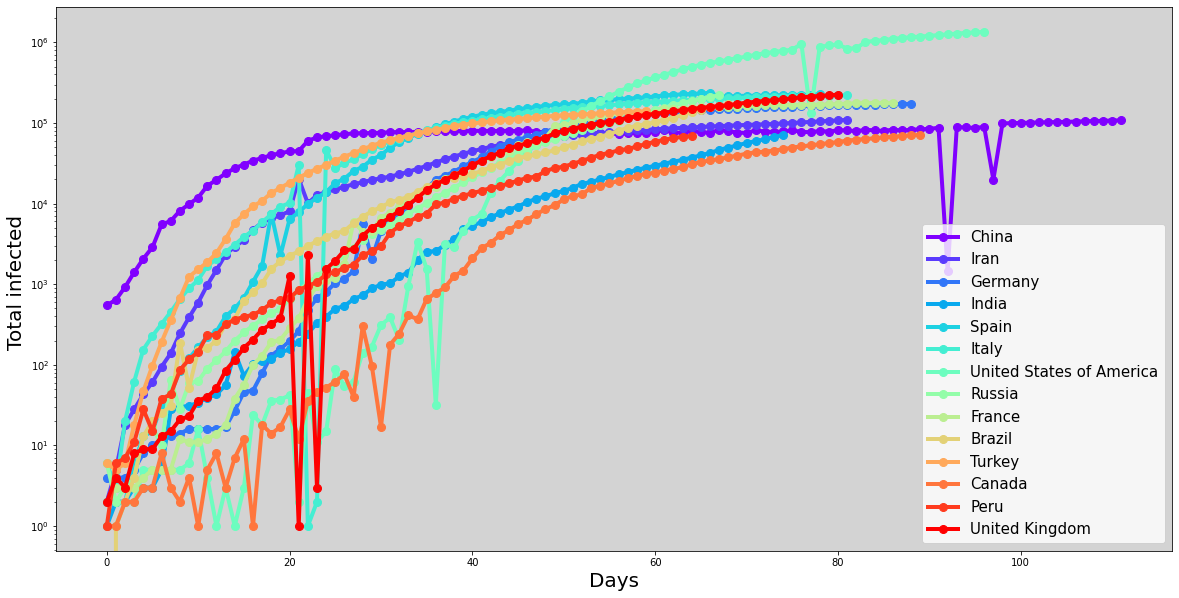

In [19]:
# Countries above india in the worldometer
Countries22 = ["China", "Iran", "Germany", "India", "Spain", "Italy", "United States of America", 
               "Russia", "France", "Brazil", "Turkey", "Canada", "Peru", "United Kingdom"]
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax1.set_ylabel('Total infected ',fontsize=20)
ax1.set_xlabel('Days',fontsize=20)

color = iter(cm.rainbow(np.linspace(0,1,len(Countries22))))
for Country in Countries22:
  df_country = df1.loc[Country]
  df_country.reset_index(inplace=True)
  orig = df_country['Confirmed'].tolist()
  c = next(color)
  ax1.plot(orig,'-o',ms=8, lw=4,c = c, label=Country)
  ax1.set_yscale('log')
  ax1.legend(fontsize=15)
ax1.set_facecolor('lightgray')

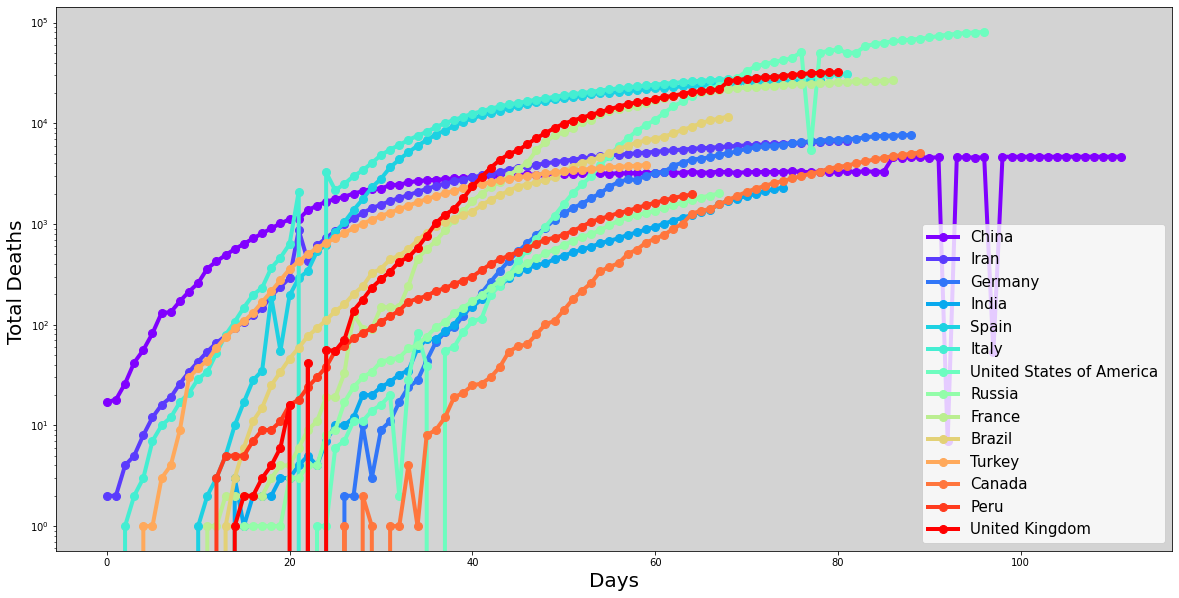

In [30]:
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax1.set_ylabel('Total Deaths ',fontsize=20)
ax1.set_xlabel('Days',fontsize=20)

color = iter(cm.rainbow(np.linspace(0,1,len(Countries22))))
for Country in Countries22:
  df_country = df1.loc[Country]
  df_country.reset_index(inplace=True)
  orig = df_country['Deaths'].tolist()
  c = next(color)
  ax1.plot(orig,'-o',ms=8, lw=4,c = c, label=Country)
  ax1.set_yscale('log')
  ax1.legend(fontsize=15)
ax1.set_facecolor('lightgray')

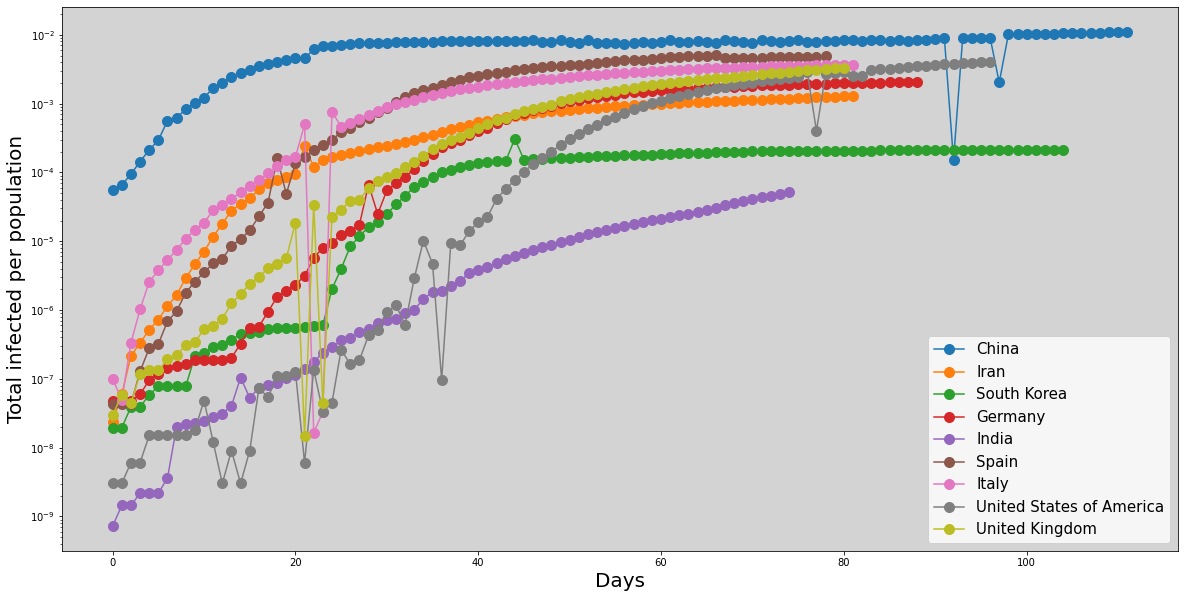

In [21]:
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax1.set_ylabel('Total infected per population',fontsize=20)
ax1.set_xlabel('Days',fontsize=20)
for Country in Countries1:
  df_country = df1.loc[Country]
  df_country.reset_index(inplace=True)
  orig = df_country['Confirmed'].tolist()
  orig = [o/population[Country]  for o in orig]
  ax1.plot(orig,'-o',ms=10,label=Country)
  ax1.set_yscale('log')
  ax1.legend(fontsize=15)
ax1.set_facecolor('lightgray')

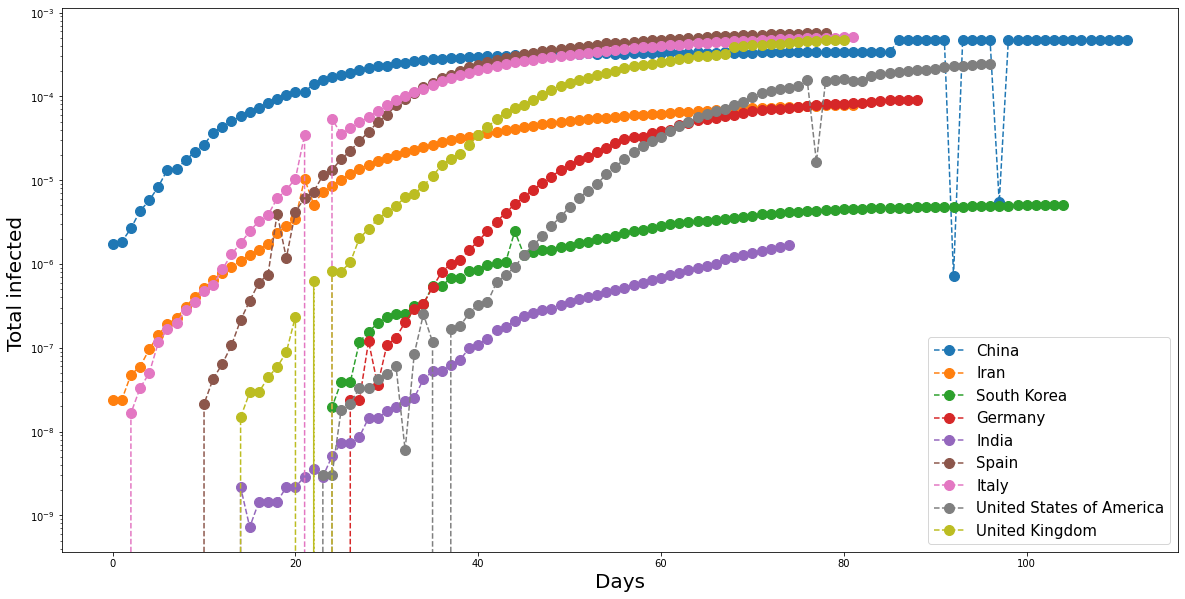

In [22]:
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
ax1.set_ylabel('Total infected ',fontsize=20)
ax1.set_xlabel('Days',fontsize=20)
for Country in Countries1:
  df_country = df1.loc[Country]
  df_country.reset_index(inplace=True)
  orig = df_country['Deaths'].tolist()
  orig = [o/population[Country]  for o in orig]
  ax1.plot(orig,'--o',ms=10,label=Country)
  ax1.set_yscale('log')
  ax1.legend(fontsize=15)

### Compare doubling time

Investigating how the doubling time is changing gives an idea how good or bad a country is doing in controlling the virus spread--
* A large doubling time is good.
* A constant doubling time - means the measures being taken are effective in controlling the spread
* An increasing doubling time means - the battle is on winning side
* A decreasing doubling time-- well danger zone ahead.  Do something fast

In [0]:
from scipy.optimize import curve_fit
def prediction_country2(Country, df1, plot=True):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
    
  x=np.array(range(df_country.shape[0]))
  y=df_country['Confirmed'].values
  #print(len(x))

 
  def func(x,a,b):
    return a*2**(x/b)
  
  list_coeff = [Country]  
  for i in range(10, len(x), 1):
    xdata = x[:i]
    ydata = y[:i]

    try:
      popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    except:
      popt = np.array([0,0])
    list_coeff.append(popt)
  
  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()

  return list_coeff


In [24]:
List = []
for Country in tqdm(Countries1):
  coeff = prediction_country2(Country, df1,plot=False)
  List.append(coeff)

100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


In [0]:
df_combines = pd.DataFrame(List).T

In [0]:
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

In [0]:
#df_combines
#Uncomment it if you like me want to see numbers.

In [0]:
def get_country_double(df,country):
  df_coeff2 = df[country].str[-1]
  df_coeff1 = df[country].str[0]
  df_coeff2.dropna(inplace=True)
  df_coeff1.dropna(inplace=True)
  df_coeff2 = df_coeff2.astype(str).astype(float)
  df_coeff1 = df_coeff1.astype(str).astype(float)
  df_double = pd.concat([df_coeff1, df_coeff2], axis=1, join='outer')
  df_double.columns = ['Coeff1','Doubling Time in Days']
  return df_double


KeyError: ignored

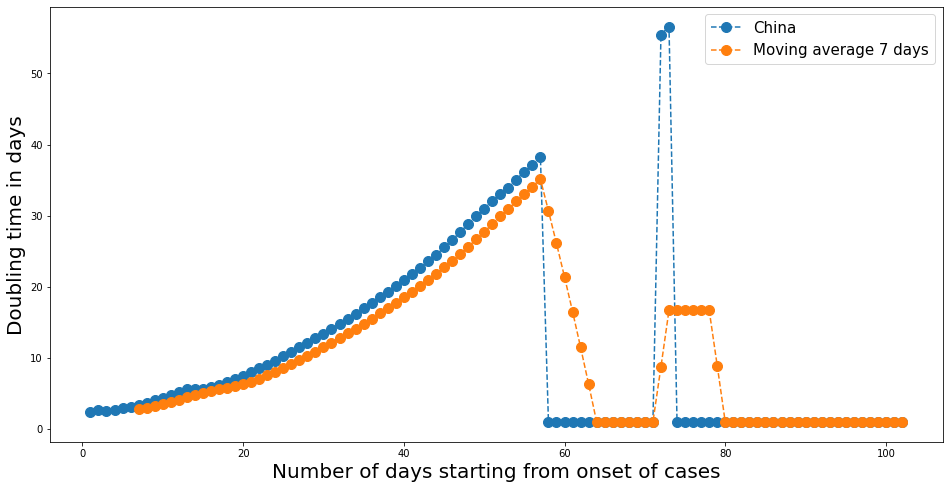

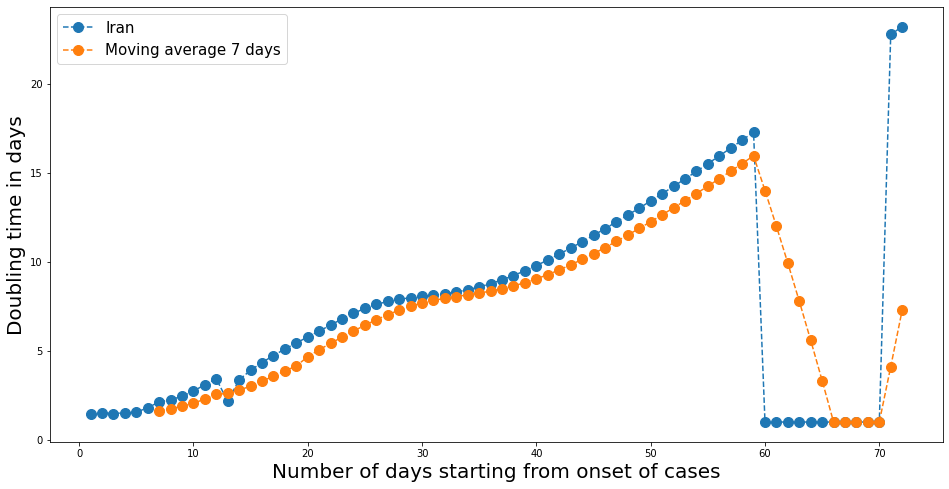

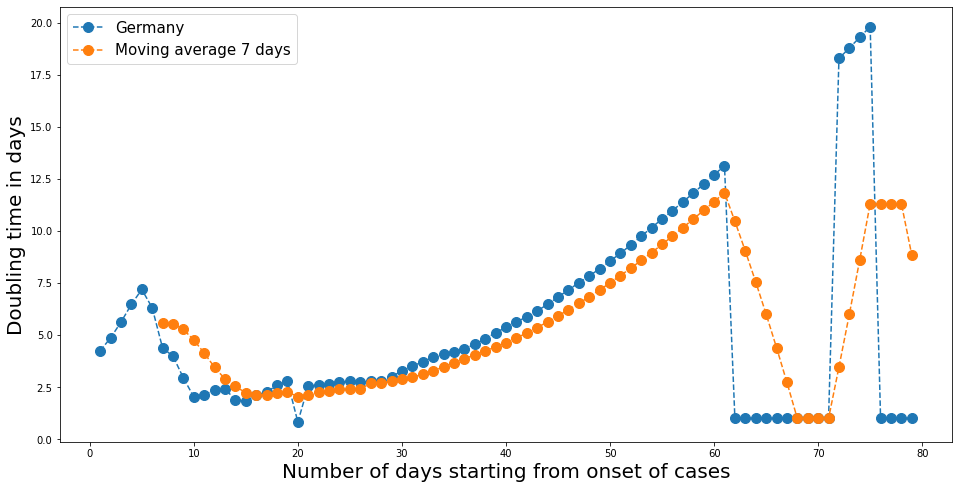

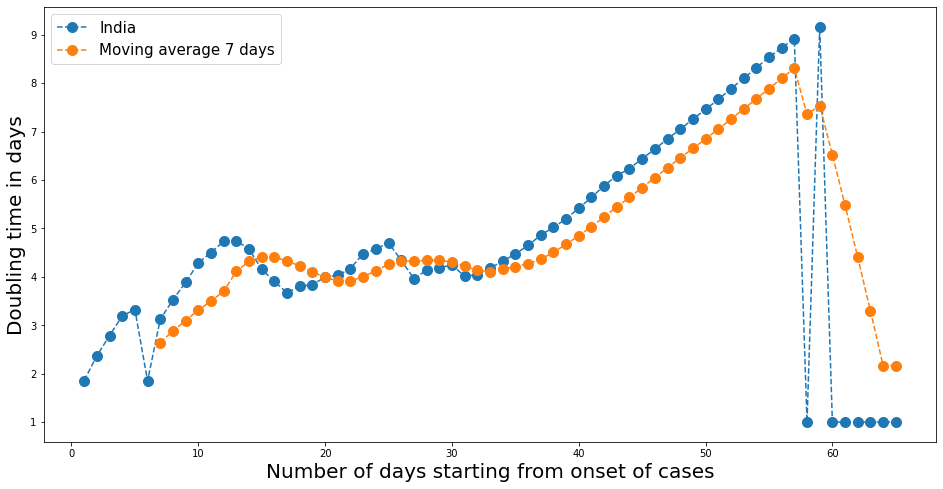

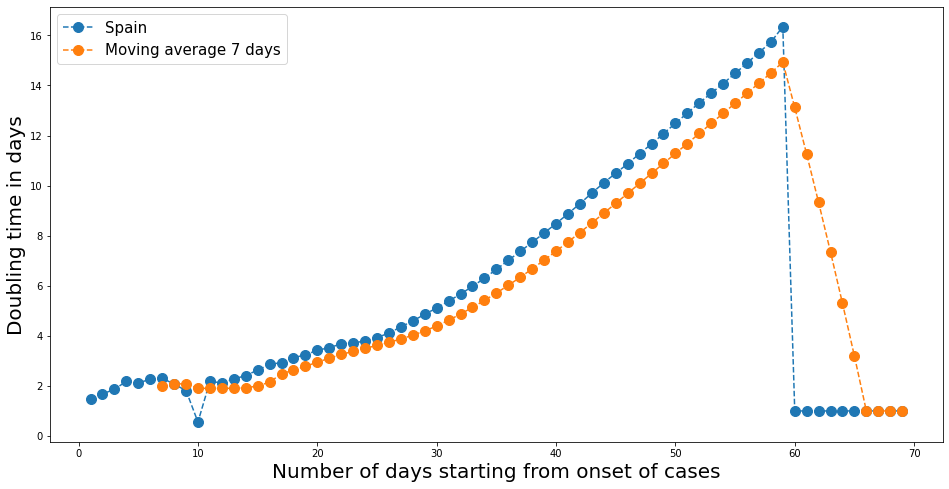

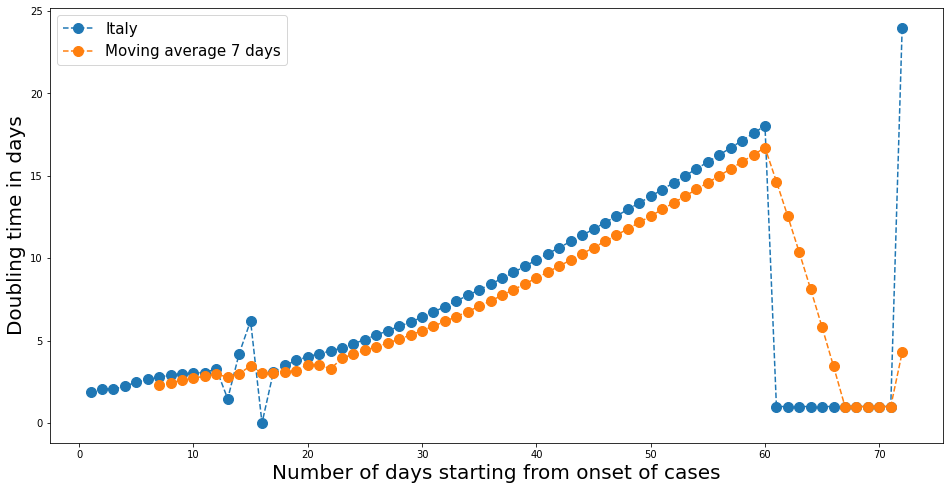

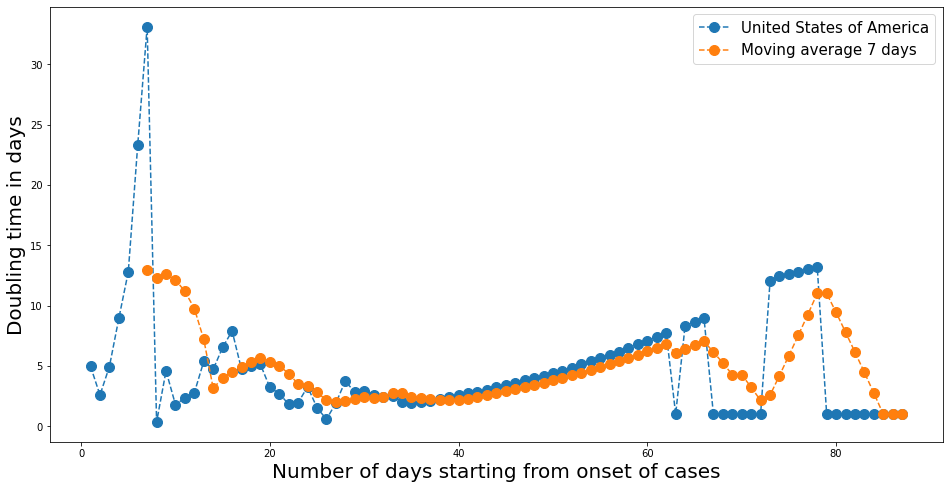

In [29]:
for country in Countries22:
  dff_double = get_country_double(df_combines, country)
  fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
  ax1.set_ylabel('Doubling time in days',fontsize=20)
  ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
  ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label=country)
  ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Moving average 7 days' )
  ax1.legend(fontsize=15)
#plt.show()

Let us zoom the graph a little

In [0]:
num = 64
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time in days',fontsize=20)
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
ax1.plot(get_country_double(df_combines,"India")['Doubling Time in Days'],'--o',ms=10,label='India')
ax1.plot(get_country_double(df_combines,"China")['Doubling Time in Days'].iloc[:num],'--*',ms=10,label='China')
#ax1.plot(df_combines['Germany'].iloc[:num],'--*',ms=10,label='Germany')
ax1.plot(get_country_double(df_combines,"Italy")['Doubling Time in Days'].iloc[:num],'--*',ms=10,label='Italy')
#ax1.plot(df_combines['Iran'].iloc[:num],'--^',ms=10,label='Iran')
ax1.plot(get_country_double(df_combines,"United Kingdom")['Doubling Time in Days'].iloc[:num],'--^',ms=10,label='United Kingdom')
ax1.plot(get_country_double(df_combines,"Spain")['Doubling Time in Days'].iloc[:num],'--^',ms=10,label='Spain')
#ax1.plot(df_combines['United States of America'].iloc[:num],'--^',ms=10,label='United States of America')
ax1.legend(fontsize=15)
#plt.show()

And now the bad but necessary task of prediction--change `loc` to see a different country. 

In [0]:
num = -7
Country = 'India'
df_country = df1.loc[Country]
df_country.reset_index(inplace=True)
orig = df_country['Confirmed'].tolist()
coeff1, coeff2 = get_country_double(df_combines,Country)['Coeff1'].iloc[num], get_country_double(df_combines,Country)['Doubling Time in Days'].iloc[num]
print(Country, coeff1, coeff2)
predictions = []
for i in range(75):
  yfit = coeff1*2**(i/coeff2)
  predictions.append(yfit)

fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax1.set_ylabel('Total infected in '+Country,fontsize=20)
ax1.set_xlabel('Days',fontsize=20)
ax1.plot(orig,'--o',ms=10,label='Real Data')
plt.plot(predictions, label='predictions')
ax1.set_yscale('log')
ax1.legend(fontsize=15)

In [0]:
Country = 'India'
df_country = df1.loc[Country]
df_country.reset_index(inplace=True)
orig = df_country['Confirmed'].tolist()
coeff1, coeff2 = get_country_double(df_combines,Country)['Coeff1'].iloc[num], get_country_double(df_combines,Country)['Doubling Time in Days'].iloc[num]
print(Country, coeff1, coeff2)
predictions = []
for i in range(75):
  yfit = coeff1*2**(i/coeff2)
  predictions.append(yfit)

fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
ax1.set_ylabel('Total infected in '+Country,fontsize=20)
ax1.set_xlabel('Days',fontsize=20)
ax1.plot(orig,'--o',ms=10,label='Real Data')
plt.plot(predictions, label='predictions')
#ax1.set_yscale('log')
ax1.legend(fontsize=15)

### What next? Are we moving in the right direction?

And now finally inspired from the [video](https://www.youtube.com/watch?v=54XLXg4fYsc&feature=youtu.be&fbclid=IwAR3H_-ZPnN6oClslsCP8_QykkTfto0wnJG7zt4WCJema2gNoG9kVVRazHnc) posted in the [FB group](https://www.facebook.com/groups/covid19global/) , I made this code to measure weekly and daily increase--the results shows all countries lie in a band-- and those who are winning the battle take a jump down.

*Almost like conduction band-valence band*

In [0]:
from scipy.optimize import curve_fit
def prediction_country3(Country, df1, plot=True,predict=False):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
  df_country['weekly_increase'] = (df_country['Confirmed']/ df_country['Confirmed'].shift(7) - 1) * 100
  df_country['daily_increase'] = (df_country['Confirmed'] / df_country['Confirmed'].shift(1) - 1) * 100

  
  x=np.array(range(df_country.shape[0]))
  y=df_country['Confirmed'].values
  #print(len(x))

 
  def func(x,a,b):
    return a*2**(x/b)
  
  list_coeff = np.zeros(df_country.shape[0]) #[Country]  
  for i in range(10, len(x), 1):
    xdata = x[:i]
    ydata = y[:i]

    try:
      popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    except:
      popt = np.array([0,0])
    list_coeff[i] = popt[1]
  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()
  if predict:
    x_new = [range(60)]
    predict_result = np.asarray([func(i, popt[0],popt[1]) for i in x_new])
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = predict_result
    #perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(yfit,'-',label=f'Exponential fit')
    ax1.legend(fontsize=15)
    plt.show()
  list_coeff = np.asarray(list_coeff)
  df_country["Doubling_time"] = list_coeff
  df_country["Country"] = [Country  for _ in range(df_country.shape[0])]
  return df_country


In [0]:
Countries1 = ["China", "Iran", "South Korea", "Germany", "India", "Spain", "Italy"]
#Countries = set(df1.reset_index()['Country/Region'].tolist())

In [0]:
dff = pd.DataFrame(columns=['Country', "Doubling_time"])
Column = "weekly_increase"
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel(Column,fontsize=20)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)

for Country in tqdm(Countries1):
  dff2 = prediction_country3(Country, df1,plot=False)
  dff2.plot("Confirmed", "weekly_increase", ls='--', marker='o', ax=ax1, ms=10,label=Country)

  dff = pd.merge(dff,dff2, how='outer')
ax1.legend(fontsize=15)

### And now view the data on world map

In [0]:
world_path = gpd.datasets.get_path('naturalearth_lowres')
World = gpd.read_file(world_path)
World.columns = ['pop_est', 'continent', 'Country', 'iso_a3', 'gdp_md_est', 'geometry']
print(len(World['Country']))
World = pd.merge(World, df_summary, on='Country',how='left')
World["Total_per_pop"] = World['Total_Confirmed_Today']/World['pop_est']*100
World.fillna(0,inplace=True)

In [0]:
title = "Total_per_pop"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Total number of Covid confirmed per population as on "+dates[-1])

In [0]:
title = "Total_Confirmed_Today"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Total number of Covid confirmed as on "+dates[-1])

In [0]:
title = "Deceased_Percent"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Deceased Percentage as on "+dates[-1])

In [0]:
title = "Recovered_Percent"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)
ax.set_title("Recovered Percentage as on "+dates[-1])

## Let us play around now a little with with different countries

First we see the daily increase of confirmed cases in some Countries

In [0]:
Countries = ["China", "Iran", "South Korea", "Germany", "India", "Spain", "Italy", "United States of America", "United Kingdom"]
for Country in tqdm(Countries22):
  plot_total(df1, Country, 'daily_increase')


Next we explore the bar graphs showing active, recovered and decesed in these counries.

In [0]:
for Country in tqdm(Countries22):
  plot_total(df1, Country, bar = True)

#### Are we near recovery

Whether a country is able to manage or not depends a lot on how good its recovery is, if the recovery of cases is equal to the confirmed cases-- the country is towards recovery. And if the the number of recovery are greater than new confirmed then the battle is about to be won.

Thus we can say that when the recovered/Confirmed ratio is above 1 the battle is won.

In [0]:
for Country in tqdm(Countries22):
  plot_total(df1, Country, 'comparative')

## Finally SIR modelling

In [0]:
def get_data(df, country):
  df_country = df.loc[Country]
  df_country.reset_index(inplace=True)
  dff =  df_country[df_country.index % 7 == 0]
  orig = dff['Confirmed'].tolist()
  return orig


In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 20000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.08, 1/27    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 1000, 360)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number in units of ('+str(N)+'s)')
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

 # adapted code from:  https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

 # Reference: https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-contact-number

In [0]:
#@title SEIR Model with Social Distancing { run: "auto" }
#@markdown 
#@markdown Reproduction number
R0 = 3.0 #@param {type:"slider", min:0.9, max:5, step:0.1}
#@markdown Disease periods in days
t_incubation = 1.2 #@param {type:"slider", min:1, max:14, step:0.1}
t_infective = 3.3 #@param {type:"slider", min:1, max:14, step:0.1}
#@markdown Population Size
N = 823276000 #@param {type:"slider", min:10000, max:3500000000, step: 1000}
#@markdown Initial number exposed
n = 3 #@param {type:"slider", min:0, max:100, step:1}
#@markdown Start of social distancing following exposure (weeks)
t_social_distancing = 3 #@param {type:"slider", min:0, max:30, step:0.1}
#@markdown Effectiveness of social distancing (0 to 100%)
u_social_distancing = 40 #@param {type:"slider", min:0, max:100, step:1}

orig = get_data(df1, 'India')

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

# initial number of infected and recovered individuals
e_initial = n/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

def step(t):
    return 1 if t >= 7*t_social_distancing else 0

# SEIR model differential equations.
def deriv(x, t, u, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -(1-u*step(t)/100)*beta * s * i
    dedt =  (1-u*step(t)/100)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 310, 310)
x_initial = s_initial, e_initial, i_initial, r_initial
s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T
s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

# plot the data
fig = plt.figure(figsize=(20, 20))
ax = [fig.add_subplot(311, axisbelow=True), 
      fig.add_subplot(312)]

pal = sns.color_palette()

ax[0].stackplot(t/7, N*s, N*e, N*i, N*r, colors=pal, alpha=0.6)
ax[0].set_title('Susceptible and Recovered Populations with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[0].set_xlabel('Weeks following Initial Campus Exposure')
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, N)
ax[0].legend([
    'Susceptible', 
    'Exposed/no symptoms', 
    'Infectious/symptomatic',
    'Recovered'], 
    loc='best')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='herd immunity')
ax[0].annotate("Start of social distancing",
    (t_social_distancing, 0), (t_social_distancing + 1.5, N/10),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("Herd Immunity without social distancing",
    (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
    arrowprops=dict(arrowstyle='->'))

ax[1].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
ax[1].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
ax[1].set_title('Infected Population with no Social Distancing and with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[1].set_xlim(0, t[-1]/7)
ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
#ax[1].set_ylim(0, 50000) # max(0.3*N, 1.05*max(N*(e + i))))
ax[1].set_xlabel('Weeks following Initial Exposure')
ax[1].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic'],
    loc='upper right')
ax[1].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)
#ax[1].plot(np.array([t_social_distancing, t_social_distancing]), 'r', lw=3)
ax[1].plot(orig, 'g--*',ms=10,label='Real Data')
y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[1].annotate("No social distancing", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[1].annotate("With {0:3.0f}% effective social distancing ".format(u_social_distancing), (t[k]/7, y[k] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()



## Additional Data
Total number of tests done per country

In [0]:
url_number_of_tests = 'https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/COVID-19%20Tests/COVID-19%20Tests.csv'
tests_df = pd.read_csv(url_number_of_tests )
tests_df.columns = ['Country','Year','Tests']
tests_df.set_index("Country", inplace = True)
tests_df.drop('Year', axis = 1, inplace = True)
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_title("Total Number of Tests", fontsize=20)
plt.xticks(rotation=90)

In [0]:
url_number_of_tests = 'https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/COVID-19%20Tests%20per%20million%20people/COVID-19%20Tests%20per%20million%20people.csv'
tests_df = pd.read_csv(url_number_of_tests )
tests_df.columns = ['Country','Year','Tests']
tests_df.set_index("Country", inplace = True)
tests_df.drop('Year', axis = 1, inplace = True)
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_title("Tests per million of the population", fontsize=20)
plt.xticks(rotation=90)

In [0]:
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_ylim(0,10)
ax.set_title("Tests per million of the population", fontsize=20)
plt.xticks(rotation=90)